# Neighbor2Neighbor Denoising
### Versions:
- 1.x: old dataset
- 2.x: 340 img dataset
| Run    | Epochs | Learning Rate | `increase_ratio` | `n_feature` | `batch` | Patchsize | Avg. PSNR | Avg. SSIM | Avg. PIQE | Avg. BRISQUE | Avg. NIQE |
| :----- | :----: | :-----------: | :--------------: | :---------: | :-----: | :-------: | :-------: | :-------: | :-------: | :----------: | :-------: |
| Original 1.x | -      | -             | -                | -           | -       |     -     |     -     |     -     | `50.13`   | `49.91`      | `8.23`    |
| **v0.1** | 100    | 3e-4          | 2.0              | 48          | 4       | 512       |     -     |     -     | 61.47     | 79.44        | 10.38     |
| **v1.0** | `200`  | 3e-4          | 2.0              | 48          | 4       | 512       |     -     |     -     | 48.74     | 66.49        | 9.35      |
| **v1.1** | 100    | `1e-4`        | 2.0              | 48          | 4       | 512       |     -     |     -     | 54.95     | 98.22        | 12.32     |
| **v1.2** | 100    | `5e-4`        | 2.0              | 48          | 4       | 512       |     -     |     -     | 53.69     | 80.27        | 10.43     |
| **v1.3** | 100    | 3e-4          | `5.0`            | 48          | 4       | 512       |     -     |     -     | 52.87     | 84.91        | 10.47     |
| **v1.4** | 100    | 3e-4          | `1.0`            | 48          | 4       | 512       |     -     |     -     | 58.94     | 80.59        | 10.60     |
| Original 2.x | -      | -             | -                | -           | -       |     -     |     -     |     -     | `59.89`   | `62.16`      | `9.44`    |
| **v2.0** | 100    | 3e-4          | 2.0              | 48          | `4`     | 512       |   55.84   |  0.9989   | 62.68     | 74.52        | 9.64      |

## Methodology Overview
This notebook implements the **Neighbor2Neighbor** algorithm for self-supervised image denoising, specifically tailored for low-dose X-ray images.

1.  **Self-Supervised Learning**: The model learns to denoise images using only the noisy images themselves, without requiring clean, noise-free targets. This is ideal for medical imaging where clean ground-truth data is often unavailable.
2.  **Neighbor Sub-sampling**: The core of the method involves generating training pairs by sub-sampling the *same* noisy image. Two sub-images (`sub1` and `sub2`) are created where their corresponding pixels were neighbors in the original image. The model is then trained to make the output of `sub1` match `sub2`.
3.  **Regularization**: A regularization term is added to the loss function. This term compares the difference between the model's output and its target with the difference between the denoised versions of the two sub-images, leading to improved performance.
4.  **U-Net Architecture**: We use a U-Net, a powerful convolutional neural network architecture with an encoder-decoder structure and skip connections, which is highly effective for image-to-image tasks like denoising.

## 1. Imports and Dependencies

In [1]:
import os
import time
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import torch.nn.functional as F
from torch.autograd import Variable
import itertools

import pyiqa
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity
from tqdm import tqdm

import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [10]:
# Encapsulate all parameters in a class for clarity and easy access
class TrainingConfig:
    # --- Data and Augmentation ---
    val_split_ratio = 0.15
    
    # --- Model and Training Hyperparameters ---
    n_feature = 48
    n_channel = 1  # Set to 1 for grayscale X-ray images
    lr = 3e-4
    gamma = 0.5
    # With a small dataset (34 images), more epochs might be beneficial.
    n_epoch = 100 
    # Adjust batch size based on your GPU memory. 4 is a safe start.
    batchsize = 4
    patchsize = 512 # images are already preprocessed to this size
    
    # Loss function weight for the regularization term
    increase_ratio = 1.0

    # --- Paths ---
    save_model_path = 'C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Final/Nei2Nei/Models'          # Base path to save model checkpoints
    save_losses_path = 'C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Final/Nei2Nei/Losses'
    save_results_path = 'C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Final/Nei2Nei/Results'

    def get_hyperparameter_string(self):
        return (f"ep{self.n_epoch}_lr{self.lr}_nf{self.n_feature}_"
                f"b{self.batchsize}_p{self.patchsize}_ir{self.increase_ratio}")
        
    if patchsize==512:
        img_dir = 'C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Final_Train_Val_Dataset_512x512'
        test_img_dir = 'C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Final_Test_Dataset_512x512'
    elif patchsize==1024:
        img_dir = 'C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Final_Train_Val_Dataset_1024x1024'
        test_img_dir = 'C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Final_Test_Dataset_1024x1024'
    elif patchsize==2048:
        img_dir = 'C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Final_Train_Val_Dataset_2048x2048'
        test_img_dir = 'C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Final_Test_Dataset_2048x2048'

# Instantiate the configuration
opt = TrainingConfig()

# Set a seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print("Configuration set.")
print(f"Image data directory: {opt.img_dir}")

Configuration set.
Image data directory: C:/Users/emanu/OneDrive - University of Cape Town/EEE4022S/Data/Final_Train_Val_Dataset_512x512


## 2. Data Loading (from Offline Augmented Dataset)

Now that we have created a large, pre-augmented training set and a separate test set, this section will load that data.

-   **Simplified Transforms**: Since all augmentations have already been applied offline, the only transformation needed here is `transforms.ToTensor()`, which converts the loaded PIL images into PyTorch tensors and normalizes their pixel values to the `[0, 1]` range.
-   **Dataset Splitting**: The code will now take the images from your new `train_val_dir`, and split them into a final training set and a validation set. The `test_dir` will be loaded separately for the final evaluation.

In [11]:
# --- Define the Dataset Class ---
class DicomTensorDataset(Dataset):
    """
    Custom Dataset for loading pre-processed X-ray images.
    Applies specified transforms to each image upon loading.
    """
    def __init__(self, file_paths, transform=None):
        super(DicomTensorDataset, self).__init__()
        self.image_files = file_paths
        self.transform = transform
        print(f'Initialized dataset with {len(self.image_files)} images.')

    def __getitem__(self, index):
        img_path = self.image_files[index]
        im = Image.open(img_path).convert('L') # Convert to grayscale
        if self.transform:
            im = self.transform(im)
        return im, os.path.basename(img_path)

    def __len__(self):
        return len(self.image_files)

# --- Define the simplified transformation ---
online_transforms = transforms.Compose([
    transforms.ToTensor()
])

# --- Load Files from the New Offline Directories ---
# Get all file paths from your new augmented train/val folder
train_val_files = sorted([os.path.join(opt.img_dir, f) for f in os.listdir(opt.img_dir)])
# Get all file paths from your new un-augmented test folder
test_files = sorted([os.path.join(opt.test_img_dir, f) for f in os.listdir(opt.test_img_dir)])

print(f"Found {len(train_val_files)} total augmented train/val images.")
print(f"Found {len(test_files)} total un-augmented test images.")

# Now, split the augmented train_val set into a final training and validation set.
val_size = int(len(train_val_files) * opt.val_split_ratio)
train_size = len(train_val_files) - val_size
generator = torch.Generator().manual_seed(42) # for reproducible splits
train_files, val_files = random_split(train_val_files, [train_size, val_size], generator=generator)
train_files, val_files = list(train_files), list(val_files) # Convert to lists

# --- Create Datasets with the simplified transform ---
train_dataset = DicomTensorDataset(train_files, transform=online_transforms)
val_dataset = DicomTensorDataset(val_files, transform=online_transforms)
test_dataset = DicomTensorDataset(test_files, transform=online_transforms)

print(f"\nDataset sizes for this run:")
print(f"  Training: {len(train_dataset)}")
print(f"  Validation: {len(val_dataset)}")
print(f"  Test: {len(test_dataset)}")

# --- Create DataLoaders ---
train_loader = DataLoader(dataset=train_dataset, num_workers=0, batch_size=opt.batchsize, shuffle=True, pin_memory=True, drop_last=True)
val_loader = DataLoader(dataset=val_dataset, num_workers=0, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, num_workers=0, batch_size=1, shuffle=False)

Found 340 total augmented train/val images.
Found 15 total un-augmented test images.
Initialized dataset with 289 images.
Initialized dataset with 51 images.
Initialized dataset with 15 images.

Dataset sizes for this run:
  Training: 289
  Validation: 51
  Test: 15



Visualizing a sample from the Training DataLoader...
Batch shape: torch.Size([4, 1, 512, 512])


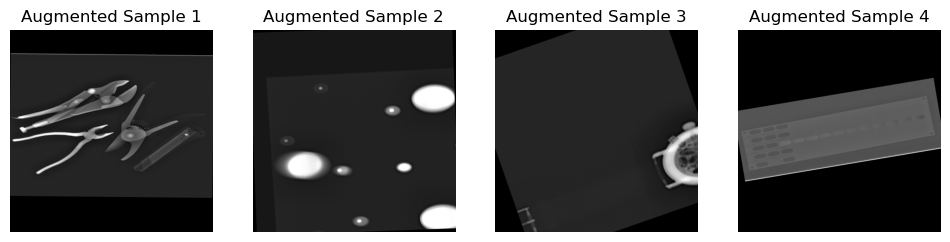

In [12]:
# # --- Visualize a Sample to Verify ---
# print("\nVisualizing a sample from the Training DataLoader...")
# sample_batch = next(iter(train_loader))
# print("Batch shape:", sample_batch.shape)

# fig, axes = plt.subplots(1, min(4, opt.batchsize), figsize=(12, 3))
# for i in range(min(4, opt.batchsize)):
#     axes[i].imshow(sample_batch[i][0].numpy(), cmap='gray')
#     axes[i].set_title(f"Augmented Sample {i+1}")
#     axes[i].axis('off')
# plt.show()

## 3. Core Neighbor2Neighbor Functions Explained

This cell contains the essential functions that implement the Neighbor2Neighbor algorithm, adapted from the original `train.py` script. These functions work together to generate the unique training pairs that allow the model to learn denoising in a self-supervised manner.

### `get_generator()`
-   **Purpose**: A utility function to create reproducible random number generators on the GPU.
-   **How it Works**: It uses a global counter (`operation_seed_counter`) to ensure that every time a random operation is needed (like adding noise or creating masks), it gets a new, unique seed. This is crucial for ensuring that the noise patterns and sub-image selections are different in each training step, while still making the entire training process reproducible if run from the beginning.

### The Sub-sampling Pipeline (The Core Idea)

The next three functions are the heart of the Neighbor2Neighbor algorithm. They work in sequence to take one noisy image and split it into two new, smaller images where every pixel in the first image was a direct neighbor of the corresponding pixel in the second image.

1.  #### `space_to_depth(x, block_size)`
    -   **Purpose**: This is a helper function for tensor manipulation. It rearranges the image data by taking spatial blocks of pixels and moving them into the channel dimension.
    -   **Analogy**: Imagine a 2x2 grid of pixels. This function effectively "flattens" that grid into a list of 4 pixels along the depth (channel) axis. This makes it much easier to select individual pixels from these blocks in the next step.

2.  #### `generate_mask_pair(img)`
    -   **Purpose**: To create two "selection masks" that decide which pixels from the original noisy image will go into `sub-image 1` and which will go into `sub-image 2`.
    -   **How it Works**: It looks at the image in 2x2 blocks. For each block, it randomly chooses a pair of adjacent pixels (e.g., the top-left and top-right, or the top-left and bottom-left). It then assigns one pixel of the pair to `mask1` and the other to `mask2`. The end result is two masks that have selected a full set of neighboring pixels.

3.  #### `generate_subimages(img, mask)`
    -   **Purpose**: To use the masks from the previous step to build the final sub-images.
    -   **How it Works**: It takes the noisy image and one of the masks. It applies the mask to select only the chosen pixels and then reshapes them into a new image that is half the height and width of the original. When you call this function once with `mask1` and once with `mask2`, you get the two sub-images that form the final training pair for the model.

In [13]:
operation_seed_counter = 0

def get_generator():
    global operation_seed_counter
    operation_seed_counter += 1
    g_cuda_generator = torch.Generator(device=device)
    g_cuda_generator.manual_seed(operation_seed_counter)
    return g_cuda_generator

def space_to_depth(x, block_size):
    n, c, h, w = x.size()
    unfolded_x = torch.nn.functional.unfold(x, block_size, stride=block_size)
    return unfolded_x.view(n, c * block_size**2, h // block_size, w // block_size)

def generate_mask_pair(img):
    n, c, h, w = img.shape
    mask1 = torch.zeros(size=(n*h//2*w//2*4,), dtype=torch.bool, device=img.device)
    mask2 = torch.zeros(size=(n*h//2*w//2*4,), dtype=torch.bool, device=img.device)
    idx_pair = torch.tensor([[0, 1], [0, 2], [1, 3], [2, 3], [1, 0], [2, 0], [3, 1], [3, 2]], dtype=torch.int64, device=img.device)
    rd_idx = torch.randint(0, 8, (n*h//2*w//2,), generator=get_generator(), device=img.device)
    rd_pair_idx = idx_pair[rd_idx]
    rd_pair_idx += torch.arange(start=0, end=n*h//2*w//2*4, step=4, dtype=torch.int64, device=img.device).reshape(-1, 1)
    mask1[rd_pair_idx[:, 0]] = 1
    mask2[rd_pair_idx[:, 1]] = 1
    return mask1, mask2

def generate_subimages(img, mask):
    n, c, h, w = img.shape
    subimage = torch.zeros(n, c, h//2, w//2, dtype=img.dtype, layout=img.layout, device=img.device)
    for i in range(c):
        img_per_channel = space_to_depth(img[:, i:i + 1, :, :], block_size=2)
        img_per_channel = img_per_channel.permute(0, 2, 3, 1).reshape(-1)
        subimage[:, i:i+1, :, :] = img_per_channel[mask].reshape(n,h//2,w//2,1).permute(0,3,1,2)
    return subimage

print("Core Neighbor2Neighbor functions defined.")

Core Neighbor2Neighbor functions defined.


### Model Architecture - Compatible U-Net

The original `arch_unet.py` file is incompatible with the newer version of PyTorch required for our evaluation libraries. To resolve this, we are defining a standard, compatible U-Net architecture directly in this cell. This model serves the exact same purpose and structure but is guaranteed to work with our current environment.

In [14]:
class UNet(nn.Module):
    def __init__(self, in_nc=1, out_nc=1, n_feature=48):
        super(UNet, self).__init__()
        self.in_conv = nn.Sequential(nn.Conv2d(in_nc, n_feature, 3, 1, 1), nn.LeakyReLU(0.1, True))
        self.conv1 = nn.Sequential(nn.Conv2d(n_feature, n_feature, 3, 1, 1), nn.LeakyReLU(0.1, True))
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Sequential(nn.Conv2d(n_feature, n_feature*2, 3, 1, 1), nn.LeakyReLU(0.1, True))
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Sequential(nn.Conv2d(n_feature*2, n_feature*4, 3, 1, 1), nn.LeakyReLU(0.1, True))
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Sequential(nn.Conv2d(n_feature*4, n_feature*8, 3, 1, 1), nn.LeakyReLU(0.1, True))
        self.pool4 = nn.MaxPool2d(2, 2)
        self.bridge = nn.Sequential(nn.Conv2d(n_feature*8, n_feature*16, 3, 1, 1), nn.LeakyReLU(0.1, True),
                                    nn.Conv2d(n_feature*16, n_feature*16, 3, 1, 1), nn.LeakyReLU(0.1, True))
        self.up4 = nn.ConvTranspose2d(n_feature*16, n_feature*8, 2, 2)
        self.dconv4 = nn.Sequential(nn.Conv2d(n_feature*16, n_feature*8, 3, 1, 1), nn.LeakyReLU(0.1, True))
        self.up3 = nn.ConvTranspose2d(n_feature*8, n_feature*4, 2, 2)
        self.dconv3 = nn.Sequential(nn.Conv2d(n_feature*8, n_feature*4, 3, 1, 1), nn.LeakyReLU(0.1, True))
        self.up2 = nn.ConvTranspose2d(n_feature*4, n_feature*2, 2, 2)
        self.dconv2 = nn.Sequential(nn.Conv2d(n_feature*4, n_feature*2, 3, 1, 1), nn.LeakyReLU(0.1, True))
        self.up1 = nn.ConvTranspose2d(n_feature*2, n_feature, 2, 2)
        self.dconv1 = nn.Sequential(nn.Conv2d(n_feature*2, n_feature, 3, 1, 1), nn.LeakyReLU(0.1, True))
        self.out_conv = nn.Conv2d(n_feature, out_nc, 3, 1, 1)

    def forward(self, x):
        c1 = self.conv1(self.in_conv(x))
        p1 = self.pool1(c1); c2 = self.conv2(p1)
        p2 = self.pool2(c2); c3 = self.conv3(p2)
        p3 = self.pool3(c3); c4 = self.conv4(p3)
        p4 = self.pool4(c4); b = self.bridge(p4)
        u4 = self.up4(b); merge4 = torch.cat([u4, c4], 1); d4 = self.dconv4(merge4)
        u3 = self.up3(d4); merge3 = torch.cat([u3, c3], 1); d3 = self.dconv3(merge3)
        u2 = self.up2(d3); merge2 = torch.cat([u2, c2], 1); d2 = self.dconv2(merge2)
        u1 = self.up1(d2); merge1 = torch.cat([u1, c1], 1); d1 = self.dconv1(merge1)
        return self.out_conv(d1)

# Instantiate the network
network = UNet(in_nc=opt.n_channel, out_nc=opt.n_channel, n_feature=opt.n_feature).to(device)
print("U-Net model created successfully using a compatible architecture.")

U-Net model created successfully using a compatible architecture.


## 4. The Training and Validation Process

### Initialization
Before the loop begins, several key components are set up:
-   **Optimizer**: We initialize the **Adam optimizer**, a popular and effective algorithm for training neural networks. It is given the `network.parameters()` so it knows which values to adjust, and a `learning_rate` (`lr`) that controls how large the adjustments are.
-   **Learning Rate Scheduler**: A `MultiStepLR` scheduler is attached to the optimizer. Its job is to automatically decrease the learning rate at specific points during training (at 20%, 40%, 60%, and 80% of the total epochs). This "cooling down" of the learning rate helps the model to make smaller, more precise adjustments as it gets closer to a good solution.
-   **Model Saving**: Directories are created to store the results, and a variable `best_val_loss` is initialized to infinity. This variable will be used to track the best-performing model on the validation set.

---

### 1. Training Phase (`network.train()`)
In this phase, the model learns by adjusting its internal parameters.
1.  **Get a Batch**: The `train_loader` provides a small batch of our noisy X-ray images.
2.  **Generate Training Pairs**: The batch of noisy images is passed to the `generate_mask_pair` and `generate_subimages` functions. This creates the two corresponding sub-images, `noisy_sub1` (the input) and `noisy_sub2` (the target), which is the core of the Neighbor2Neighbor method.
3.  **Calculate the Loss**: The model processes `noisy_sub1` to produce a denoised `noisy_output`. The total loss is then calculated in two parts:
    -   `loss1`: This is the primary **reconstruction loss**. It measures the direct pixel-wise difference (Mean Squared Error) between the model's `noisy_output` and the `noisy_target`. This forces the model to learn how to make neighboring pixels look like each other.
    -   `loss2`: This is the **regularization loss**. It's a clever term that helps stabilize training and improve performance. It encourages the *difference* between the model's output and its target to be similar to the *difference* between two denoised versions of the sub-images. The `Lambda` variable scales this loss, making it more influential as training progresses.
4.  **Backpropagation**: The final combined `loss_all` is a single number representing how "wrong" the model was for this batch. `loss_all.backward()` calculates how much each parameter in the model contributed to this error.
5.  **Update Weights**: `optimizer.step()` uses the information from backpropagation to update the model's parameters, nudging them in the right direction to reduce the error on the next batch.
6.  **Repeat**: This process repeats for all batches until the model has seen the entire training set for the current epoch.

---

### 2. Validation Phase (`network.eval()`)

After each training epoch, we must check how well the model is generalizing to data it hasn't been trained on. Since our validation set also consists of **only noisy images**.
We use a **self-supervised validation** strategy. We calculate the exact same **Neighbor2Neighbor loss** on the validation images that we used during training.

1.  **Calculate Validation Loss**: For each noisy image in the `val_loader`, we perform the same sub-sampling process as in training to create `sub-image 1` and `sub-image 2`. The model's output from `sub-image 1` is compared to `sub-image 2`, and the full Neighbor2Neighbor loss (`loss_all`) is calculated.
2.  **Interpret the Loss**: In this context, a lower validation loss means the model is becoming more **consistent** and is applying its learned denoising rules effectively to new, unseen noisy images. It's a measure of how well the core denoising logic is generalizing.
3.  **Save the Best Model**: The average validation loss for the epoch is compared to the `best_val_loss` seen so far.

In [ ]:
optimizer = optim.Adam(network.parameters(), lr=opt.lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(x * opt.n_epoch) for x in [0.2, 0.4, 0.6, 0.8]], gamma=opt.gamma)

# --- MODIFIED: Get hyperparam string for filenames ---
hyperparam_str = opt.get_hyperparameter_string()
print(f"Using hyperparameter string: {hyperparam_str}")

# --- Model Saving Setup ---
save_model_dir = os.path.join(opt.save_model_path, hyperparam_str)
os.makedirs(save_model_dir, exist_ok=True)
print(f"Models and logs will be saved to: {save_model_dir}")

# --- Lists to store loss history for plotting ---
train_loss_history = []
val_loss_history = []

# --- TRAINING & VALIDATION ---
start_time = time.time()
best_val_loss = float('inf')

for epoch in range(1, opt.n_epoch + 1):
    # --- Training Phase ---
    network.train()
    epoch_train_loss = 0
    train_iterator = tqdm(train_loader, desc=f"Training Epoch {epoch}/{opt.n_epoch}")
    
    for i, (noisy_image_batch, _) in enumerate(train_iterator):
        noisy = noisy_image_batch.to(device)

        optimizer.zero_grad()
        mask1, mask2 = generate_mask_pair(noisy)
        noisy_sub1 = generate_subimages(noisy, mask1)
        noisy_sub2 = generate_subimages(noisy, mask2)

        with torch.no_grad():
            noisy_denoised = network(noisy)
        noisy_sub1_denoised = generate_subimages(noisy_denoised, mask1)
        noisy_sub2_denoised = generate_subimages(noisy_denoised, mask2)

        noisy_output = network(noisy_sub1)
        noisy_target = noisy_sub2

        Lambda = epoch / opt.n_epoch * opt.increase_ratio
        diff = noisy_output - noisy_target
        exp_diff = noisy_sub1_denoised - noisy_sub2_denoised

        loss1 = torch.mean(diff**2)
        loss2 = Lambda * torch.mean((diff - exp_diff)**2)
        loss_all = loss1 + loss2

        loss_all.backward()
        optimizer.step()
        epoch_train_loss += loss_all.item()
        train_iterator.set_postfix({'loss': loss_all.item()})

    # --- Validation Phase ---
    network.eval()
    epoch_val_loss = 0
    val_iterator = tqdm(val_loader, desc=f"Validation Epoch {epoch}/{opt.n_epoch}")
    with torch.no_grad():
        for i, (noisy_val_image, _) in enumerate (val_iterator):
            noisy_val = noisy_val_image.to(device)

            mask1_val, mask2_val = generate_mask_pair(noisy_val)
            noisy_sub1_val = generate_subimages(noisy_val, mask1_val)
            noisy_sub2_val = generate_subimages(noisy_val, mask2_val)

            noisy_denoised_val = network(noisy_val)
            noisy_sub1_denoised_val = generate_subimages(noisy_denoised_val, mask1_val)
            noisy_sub2_denoised_val = generate_subimages(noisy_denoised_val, mask2_val)

            noisy_output_val = network(noisy_sub1_val)

            diff_val = noisy_output_val - noisy_sub2_val
            exp_diff_val = noisy_sub1_denoised_val - noisy_sub2_denoised_val

            val_loss1 = torch.mean(diff_val**2)
            val_loss2 = Lambda * torch.mean((diff_val - exp_diff_val)**2)
            val_loss_all = val_loss1 + val_loss2
            epoch_val_loss += val_loss_all.item()
            val_iterator.set_postfix({'val_loss': val_loss_all.item()})

    scheduler.step()

    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_val_loss = epoch_val_loss / len(val_loader)

    # Append the calculated losses to the lists for plotting
    train_loss_history.append(avg_train_loss)
    val_loss_history.append(avg_val_loss)

    print(f"Epoch [{epoch}/{opt.n_epoch}] | Avg Train Loss: {avg_train_loss:.6f} | Avg Val Loss: {avg_val_loss:.6f}")

    # --- Save Best Model ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_name = f"best_model.pth"
        best_model_path = os.path.join(save_model_dir, best_model_name)
        torch.save(model.state_dict(), best_model_path)
        print(f'   -> New best model saved to {best_model_path}')

# --- Save Final Model ---
final_model_name = f"final_model.pth"
final_model_path = os.path.join(save_model_dir, final_model_name)
torch.save(model.state_dict(), final_model_path)
print(f'   -> Final model saved to {final_model_path}')

end_time = time.time()
print(f"\n--- Training Finished ---")
print(f"Total training time: {(end_time - start_time) / 60:.2f} minutes")

# --- MODIFIED: Save Loss History to CSV ---
print(f"\nSaving loss history to CSV...")
losses_df = pd.DataFrame({
    'epoch': range(1, opt.n_epoch + 1),
    'train_loss': train_loss_history,
    'val_loss': val_loss_history
})
losses_csv_name = f"{hyperparam_str}.csv"
losses_csv_path = os.path.join(opt.save_losses_path, losses_csv_name)
losses_df.to_csv(losses_csv_path, index=False)
print(f"Loss history saved to {losses_csv_path}")

## 5. Analysis of Learning Curves

Plotting the training and validation loss over each epoch is the most effective way to diagnose the model's learning behavior.

-   **Training Loss**: This curve shows how well the model is learning from the training data. A steadily decreasing line indicates that the model is successfully minimizing its error.
-   **Validation Loss**: This curve shows how well the model is generalizing to unseen data. It is the most important indicator of the model's true performance.

By observing these two curves together, we can identify ideal learning, overfitting, or underfitting. For instance, if the training loss continues to decrease while the validation loss starts to increase, it's a clear sign of overfitting.

In [ ]:
# # --- Plotting the training and validation loss ---
# plt.figure(figsize=(12, 5))
# plt.plot(range(1, opt.n_epoch + 1), train_losses, label='Training Loss')
# plt.plot(range(1, opt.n_epoch + 1), val_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss Curves')
# plt.legend()
# plt.grid(True)
# plt.show()

## Final Model Evaluation on Unseen Test Data

This section performs a comprehensive evaluation of the trained **Neighbor2Neighbor** model on the unseen test set. To ensure a fair comparison with the `Noise2Self` model, we will use the identical evaluation methodology.

### Evaluation Strategy
Since we do not have access to clean, noise-free ground truth images, our evaluation is based on two approaches:

1.  **No-Reference Image Quality Assessment (NR-IQA)**: We use three standard NR-IQA metrics to quantitatively measure image quality. These metrics analyze images for artifacts, sharpness, and naturalness without needing a reference. For denoising, a **lower score is better**, indicating a higher quality image.
    -   **PIQE** (Perception-based Image Quality Evaluator)
    -   **BRISQUE** (Blind/Referenceless Image Spatial Quality Evaluator)
    -   **NIQE** (Natural Image Quality Evaluator)

2.  **Qualitative Visual Analysis**: We will visually inspect the results by plotting three images for each test sample:
    -   The original **Noisy Input**.
    -   The **Denoised Output** from the model.
    -   The **Residual Image** (Noisy - Denoised), which shows exactly what information the model identified and removed as "noise."

This combined approach allows us to both quantify the improvement in image quality and visually verify the model's denoising behavior.

In [ ]:
# --- Setup ---
print("\n--- Starting Final Evaluation on Test Set ---")
# --- Create IQA metric models ---
niqe_metric = pyiqa.create_metric('niqe', device=device)
piqe_metric = pyiqa.create_metric('piqe', device=device)
brisque_metric = pyiqa.create_metric('brisque', device=device)

# --- Load the Best Model ---
model_path = os.path.join(save_model_dir, "best_model.pth")

state_dict = torch.load(model_path, weights_only=True)
network.load_state_dict(state_dict)
network.eval()
print(f"Loaded best model for evaluation: {model_path}\n")

# --- Prepare storage ---
results_data = []
original_images_np, denoised_images_np, residuals = [], [], []
psnr_scores = []
original_piqe_scores, denoised_piqe_scores = [], []
original_brisque_scores, denoised_brisque_scores = [], []
original_niqe_scores, denoised_niqe_scores = [], []

test_iterator = tqdm(test_loader, desc="Evaluating Test Set")

# --- Evaluation ---
with torch.no_grad():
    for i, (original_image_batch, filename_batch) in enumerate(test_iterator):
        original_image_tensor = original_image_batch.to(device)  # (1, 1, H, W)
        filename = filename_batch[0]

        # --- Model inference ---
        denoised_image_tensor = model(original_image_tensor).clamp(0, 1)

        # --- Compute IQA metrics (directly on tensors, no numpy) ---
        original_niqe = niqe_metric(original_image_tensor).item()
        denoised_niqe = niqe_metric(denoised_image_tensor).item()
        original_piqe = piqe_metric(original_image_tensor).item()
        denoised_piqe = piqe_metric(denoised_image_tensor).item()
        original_brisque = brisque_metric(original_image_tensor).item()
        denoised_brisque = brisque_metric(denoised_image_tensor).item()

        # --- Convert to NumPy for PSNR and saving ---
        original_image_np = original_image_tensor.cpu().numpy()[0, 0]
        denoised_image_np = denoised_image_tensor.cpu().numpy()[0, 0]
        residual_np = original_image_np - denoised_image_np

        # --- Metrics ---
        psnr = compare_psnr(original_image_np, denoised_image_np)

        # --- Store all results ---
        original_images_np.append(original_image_np)
        denoised_images_np.append(denoised_image_np)
        residuals.append(residual_np)

        psnr_scores.append(psnr)
        original_niqe_scores.append(original_niqe)
        denoised_niqe_scores.append(denoised_niqe)
        original_piqe_scores.append(original_piqe)
        denoised_piqe_scores.append(denoised_piqe)
        original_brisque_scores.append(original_brisque)
        denoised_brisque_scores.append(denoised_brisque)

        results_data.append({
            'filename': filename,
            'psnr': psnr,
            'piqe': denoised_piqe,
            'original_piqe': original_piqe,
            'brisque': denoised_brisque,
            'original_brisque': original_brisque,
            'niqe': denoised_niqe,
            'original_niqe': original_niqe
        })

# --- Save per-image metrics to CSV ---
save_results_dir = os.path.join(opt.save_results_path, opt.get_hyperparameter_string())
os.makedirs(save_results_dir, exist_ok=True)
csv_path = os.path.join(save_results_dir, "results.csv")

results_df = pd.DataFrame(results_data)
results_df = results_df[['filename', 'psnr', 'piqe', 'original_piqe',
                         'brisque', 'original_brisque', 'niqe', 'original_niqe']]
results_df.to_csv(csv_path, index=False, float_format='%.4f')
print(f"Metrics saved to {csv_path}")

# --- Save average metrics ---
avg_metrics = {
    'run_name' : hyperparam_str,
    'avg_psnr': np.mean(psnr_scores),
    'avg_piqe': np.mean(denoised_piqe_scores),
    'avg_original_piqe': np.mean(original_piqe_scores),
    'avg_brisque': np.mean(denoised_brisque_scores),
    'avg_original_brisque': np.mean(original_brisque_scores),
    'avg_niqe': np.mean(denoised_niqe_scores),
    'avg_original_niqe': np.mean(original_niqe_scores),
}

# --- Append to or create general CSV ---
all_runs_csv = os.path.join(opt.save_results_path, "avg_results.csv")

if os.path.exists(all_runs_csv):
    df_all = pd.read_csv(all_runs_csv)
    df_all = pd.concat([df_all, pd.DataFrame([avg_metrics])], ignore_index=True)
else:
    df_all = pd.DataFrame([avg_metrics])

df_all.to_csv(all_runs_csv, index=False)
print(f"\nAverage results appended to: {all_runs_csv}")

# --- Save denoised images and residuals ---
denoised_dir = os.path.join(save_results_dir, "denoised_images")
residual_dir = os.path.join(save_results_dir, "residuals")
os.makedirs(denoised_dir, exist_ok=True)
os.makedirs(residual_dir, exist_ok=True)

for i, filename in enumerate(results_df['filename']):
    denoised_uint8 = (np.clip(denoised_images_np[i], 0, 1) * 255).astype(np.uint8)
    residual_display = (residuals[i] - residuals[i].min()) / (np.ptp(residuals[i]) + 1e-8)
    residual_uint8 = (residual_display * 255).astype(np.uint8)

    Image.fromarray(denoised_uint8).save(os.path.join(denoised_dir, f"{filename}.png"))
    Image.fromarray(residual_uint8).save(os.path.join(residual_dir, f"{filename}_residual.png"))

print("All denoised images and residuals saved successfully.")
print("------------------------------------------------")

## Hyperparameter Tuning and Experimentation
Below are the most impactful parameters to experiment with, categorized by their potential impact.

### 1: Core Training Hyperparameters
These parameters control the fundamental learning process and often have the most significant impact.

#### a. Number of Epochs (`n_epoch`)
-   **Why it Matters**: dataset is very small (~70 training images) compared to the 40,000+ images the original model was trained on. It's highly likely the model simply needs more time to see the data and learn the noise patterns.
-   **Recommendation**: **Increase the number of epochs**. Try doubling the value to **200** and observe the loss curve.

#### b. Learning Rate (`lr`)
-   **Why it Matters**: dictates the size of the steps the model takes to correct its errors. Too high, and it can become unstable; too low, and it learns too slowly.
-   **Recommendation**: **lower learning rate**. A smaller `lr` can lead to more stable and consistent convergence, often beneficial for small datasets. The default is `3e-4`. Good alternatives to test are `1e-4` (0.0001) or `5e-5` (0.00005).

### 2: Algorithm-Specific Hyperparameters
This parameter is unique to the Neighbor2Neighbor loss function and directly affects how it behaves.

#### a. Regularization Weight (`increase_ratio`)
-   **Why it Matters**: This parameter controls the strength of the special regularization term (`loss2`) in the loss function. This term is what helps the model produce more stable and artifact-free results.
-   **Recommendation**: Experiment with both increasing and decreasing this value from the default of `2.0`.
    -   **Increase to `4.0` or `5.0`**: This strengthens the regularization, which can help if your denoised images look blurry or have unnatural-looking patterns.
    -   **Decrease to `1.0`**: If the model is being too conservative and not removing enough noise, reducing this weight might help.

### 3: Model Architecture
This involves altering the model's structure to better fit the complexity of your data.

#### a. Model Capacity (`n_feature`)
-   **Why it Matters**: This parameter defines the number of channels in the U-Net's first layer, which in turn scales the entire network's size. A larger model has more capacity to learn but is also more likely to overfit a small dataset.
-   **Recommendation**: The current value is `48`.
    -   **Decrease to `32`**: If your training loss gets very low but your validation loss stays high or increases (a sign of overfitting), a smaller model might generalize better.
    -   **Increase to `64`**: If both your training and validation loss plateau very early (a sign of underfitting), a larger model might be able to learn more from the data. Use this with caution on a small dataset.